[View in Colaboratory](https://colab.research.google.com/github/shivamgoel1791/Email_click_rate_AnalyticsVidhya/blob/master/Email_click_rate_Embeddings.ipynb)

## Email click rate embeddings

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

In [58]:
from google.colab import files
uploaded = files.upload()

Saving campaign_data.csv to campaign_data.csv


In [0]:
path = '/content'

In [60]:
!ls

campaign_data.csv  datalab  fastai  tmp		 train.csv
data		   drive    models  train_1.csv


In [0]:
#!rm -rf models

We're working with the movielens data, which contains one rating per row, like this:

In [9]:
ratings = pd.read_csv('train_1.csv')
ratings.head()

,id,user_id,campaign_id,send_date,is_open,is_click
0,42_14051,14051,42,01-09-2017 19:55,0,0
1,52_134438,134438,52,02-11-2017 12:53,0,0
2,33_181789,181789,33,24-07-2017 15:15,0,0
3,44_231448,231448,44,05-09-2017 11:36,0,0
4,29_185580,185580,29,01-07-2017 18:01,0,0


In [61]:
movies = pd.read_csv('campaign_data.csv')
movies.head()

,campaign_id,communication_type,total_links,no_of_internal_links,no_of_images,no_of_sections,email_body,subject,email_url
0,29,Newsletter,67,61,12,3,"Dear AVians,\r\n \r\nWe are shaping up a super...",Sneak Peek: A look at the emerging data scienc...,http://r.newsletters.analyticsvidhya.com/7um44...
1,30,Upcoming Events,18,14,7,1,"Dear AVians,\r\n \r\nAre your eager to know wh...",[July] Data Science Expert Meetups & Competiti...,http://r.newsletters.analyticsvidhya.com/7up0e...
2,31,Conference,15,13,5,1,Early Bird Pricing Till August 07  Save upto ...,Last chance to convince your boss before the E...,http://r.newsletters.analyticsvidhya.com/7usym...
3,32,Conference,24,19,7,1,\r\n \r\nHi ?\r\n \r\nBefore I dive into why y...,A.I. & Machine Learning: 5 reasons why you sho...,http://r.newsletters.analyticsvidhya.com/7uthl...
4,33,Others,7,3,1,1,Fireside Chat with DJ Patil - the master is he...,"[Delhi NCR] Fireside Chat with DJ Patil, Forme...",http://r.newsletters.analyticsvidhya.com/7uvlg...


## Collaborative filtering

In [0]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4
n_factors = 5

In [0]:
cf = CollabFilterDataset.from_csv(path, 'train.csv', 'user_id', 'campaign_id', 'is_open')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [115]:
learn.fit(1e-2, 1, wds=wd, cycle_len=1, cycle_mult=1)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   
    0      0.084873   0.086543  



[0.086542755]

Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [117]:
math.sqrt(0.086542755)

0.2941815000981537

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [0]:
preds = learn.predict()

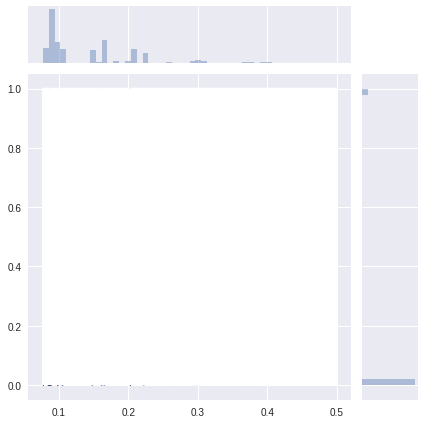

In [119]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Analyze results

### Movie bias

In [0]:
movie_names = movies.set_index('campaign_id')['subject'].to_dict()
g=ratings.groupby('campaign_id')['is_open'].count()
topMovies=g.sort_values(ascending=False).index.values[:]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

In [142]:
user_ids_names = ratings.set_index('user_id').to_dict()
g_user=ratings.groupby('user_id')['is_open'].count()
topusers=g_user.sort_values(ascending=False).index.values[:]
#topUsersIdx = np.array([cf.item2idx[o] for o in topusers])

KeyError: ignored

In [123]:
m=learn.model; m.cuda()

EmbeddingDotBias(
  (u): Embedding(168236, 5)
  (i): Embedding(26, 5)
  (ub): Embedding(168236, 1)
  (ib): Embedding(26, 1)
)

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [131]:
movie_bias = to_np(m.ib(V(topMovieIdx)))
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

movie_emb = to_np(m.i(V(topMovieIdx)))
movie_ratings_emb = [(b[:], movie_names[i]) for i,b in zip(topMovies,movie_emb)]



movie_emb_pd = pd.DataFrame(movie_ratings_emb)
movie_emb_pd.to_csv("movie_emb_pd.csv")

from google.colab import files
files.download("movie_emb_pd.csv")

[(-1.3623328, '[November Updates] - Announcing DataFest 2018, Mumbai'),
 (-2.465761,
  "[Register Now] Just 2 days to go for India's biggest action in Artificial Intelligence & Machine Learning."),
 (-2.3658864,
  '[Newsletter] Stage for DataHack Summit 2017 is set! Announcing new hackathons, articles and job opportunities !'),
 (-2.3555567,
  "Register @ DataHack Summit 2017 - India's Largest Conference On Artificial Intelligence & Machine Learning"),
 (-2.3186877,
  '[September] Exciting days ahead with DataHack Summit 2017, Hackathons, Meetups and more!'),
 (-1.7421385,
  'Dr Kirk Borne of Booz Allen Hamilton, to keynote at DataHack Summit 2017'),
 (-2.3293278,
  '[AV Newsletter] Fireside Chat with DJ Patil, DataHack Summit, and much more'),
 (-1.6443048,
  '[July] Data Science Expert Meetups & Competitions coming your way'),
 (-1.615762,
  'A.I. & Machine Learning: 5 reasons why you should attend DataHack Summit 2017'),
 (-2.2010145, 'Sneak Peek: A look at the emerging data science

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [71]:
sorted(movie_ratings, key=lambda o: o[0])[:]

[(-2.4668038,
  "[Register Now] Just 2 days to go for India's biggest action in Artificial Intelligence & Machine Learning."),
 (-2.364487,
  '[Newsletter] Stage for DataHack Summit 2017 is set! Announcing new hackathons, articles and job opportunities !'),
 (-2.3513267,
  "Register @ DataHack Summit 2017 - India's Largest Conference On Artificial Intelligence & Machine Learning"),
 (-2.346448,
  '[AV Newsletter] Fireside Chat with DJ Patil, DataHack Summit, and much more'),
 (-2.3440156,
  '[September] Exciting days ahead with DataHack Summit 2017, Hackathons, Meetups and more!'),
 (-2.1980112, '[October 2017] - Just a month to go! DataHack Summit 2017'),
 (-2.1930432, 'Sneak Peek: A look at the emerging data science world !'),
 (-2.142389,
  '[October] Data Science Hackathons, Meetups and Webinars coming your way'),
 (-2.1156282,
  '[September] Data Science Hackathons, Meetups and Webinars coming your way'),
 (-1.7564697,
  'Dr Kirk Borne of Booz Allen Hamilton, to keynote at DataHac

In [72]:
sorted(movie_ratings, key=itemgetter(0))[:]

[(-2.4668038,
  "[Register Now] Just 2 days to go for India's biggest action in Artificial Intelligence & Machine Learning."),
 (-2.364487,
  '[Newsletter] Stage for DataHack Summit 2017 is set! Announcing new hackathons, articles and job opportunities !'),
 (-2.3513267,
  "Register @ DataHack Summit 2017 - India's Largest Conference On Artificial Intelligence & Machine Learning"),
 (-2.346448,
  '[AV Newsletter] Fireside Chat with DJ Patil, DataHack Summit, and much more'),
 (-2.3440156,
  '[September] Exciting days ahead with DataHack Summit 2017, Hackathons, Meetups and more!'),
 (-2.1980112, '[October 2017] - Just a month to go! DataHack Summit 2017'),
 (-2.1930432, 'Sneak Peek: A look at the emerging data science world !'),
 (-2.142389,
  '[October] Data Science Hackathons, Meetups and Webinars coming your way'),
 (-2.1156282,
  '[September] Data Science Hackathons, Meetups and Webinars coming your way'),
 (-1.7564697,
  'Dr Kirk Borne of Booz Allen Hamilton, to keynote at DataHac

In [73]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:]

[(-0.00617319, 'Innovate and grow your business through Data Hackathons'),
 (-0.3644449,
  'Click Prediction | Data Science Hackathon | Win upto INR 2 lacs'),
 (-0.39676368,
  '[New Webinar] Can non programmers join Big Data and Data Science roles?'),
 (-0.5566327,
  '[Data Science Hackathons] Cross -Sell & Churn Prediction | Win Prizes ~ INR 1,50,000'),
 (-0.8246662,
  '[Starts Tonight] Click Prediction Hackathon | Win upto INR 2 lacs'),
 (-0.8258748,
  'Last chance to convince your boss before the Early Bird expires !'),
 (-0.8573242,
  '[New Hackathon] CodeFest by IIT BHU | Win Prizes worth INR 50,000'),
 (-0.89357734,
  "Participate at DataHack Summit 2017 - India's largest A.I. & M.L. Conference"),
 (-0.92307377, 'Watch Live: Fireside Chat with DJ Patil'),
 (-0.9885325,
  'Visualizing Machine Learning with Anand S, CEO of Gramener, at #DHS2017'),
 (-1.2417206, '[Last Day] Early Bird Offer on conference passes ENDS today'),
 (-1.2473747,
  '[Delhi NCR] Fireside Chat with DJ Patil, 

### Embedding interpretation

We can now do the same thing for the embeddings.

In [0]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_ratings_emb = [(b[:], movie_names[i]) for i,b in zip(topMovies,movie_emb)]

movie_emb_pd = pd.DataFrame(movie_ratings_emb)
movie_emb_pd.to_csv("movie_emb_pd.csv")

from google.colab import files
files.download("movie_emb_pd.csv")

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [75]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

/usr/local/lib/python3.6/dist-packages/sklearn/decomposition/pca.py:425: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var


In [76]:
movie_pca.shape

(3, 26)

In [0]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [78]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:]

[(0.15290938,
  'A.I. & Machine Learning: 5 reasons why you should attend DataHack Summit 2017'),
 (0.14092855,
  '[Data Science Hackathons] Cross -Sell & Churn Prediction | Win Prizes ~ INR 1,50,000'),
 (0.046106957,
  'Dr Kirk Borne of Booz Allen Hamilton, to keynote at DataHack Summit 2017'),
 (0.039732017,
  '[Starts Tonight] Click Prediction Hackathon | Win upto INR 2 lacs'),
 (0.018389037, '[October 2017] - Just a month to go! DataHack Summit 2017'),
 (0.008207125, 'Sneak Peek: A look at the emerging data science world !'),
 (0.0037799152,
  '[New Webinar] Can non programmers join Big Data and Data Science roles?'),
 (0.002669024, 'Watch Live: Fireside Chat with DJ Patil'),
 (0.002316012,
  '[October] Data Science Hackathons, Meetups and Webinars coming your way'),
 (0.0014912236,
  'Last chance to convince your boss before the Early Bird expires !'),
 (0.00063764,
  '[September] Exciting days ahead with DataHack Summit 2017, Hackathons, Meetups and more!'),
 (0.00024148329,
  '[

In [79]:
sorted(movie_comp, key=itemgetter(0))[:]

[(-0.93407524, '[November Updates] - Announcing DataFest 2018, Mumbai'),
 (-0.1667656,
  '[Delhi NCR] Fireside Chat with DJ Patil, Former US Chief Data Scientist'),
 (-0.15687716,
  '[Newsletter] Stage for DataHack Summit 2017 is set! Announcing new hackathons, articles and job opportunities !'),
 (-0.123653136,
  '[New Hackathon] CodeFest by IIT BHU | Win Prizes worth INR 50,000'),
 (-0.11034224,
  '[July] Data Science Expert Meetups & Competitions coming your way'),
 (-0.009657177,
  "Register @ DataHack Summit 2017 - India's Largest Conference On Artificial Intelligence & Machine Learning"),
 (-0.008448622,
  'Click Prediction | Data Science Hackathon | Win upto INR 2 lacs'),
 (-0.0061849584,
  '[Last Day] Early Bird Offer on conference passes ENDS today'),
 (-0.00514525, 'Early Bird offer expires in 2 Days. Save your spot now!'),
 (-0.0018993318,
  "[Register Now] Just 2 days to go for India's biggest action in Artificial Intelligence & Machine Learning."),
 (-0.0013244881,
  '[Sep

In [0]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [81]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:]

[(0.7931162,
  '[Newsletter] Stage for DataHack Summit 2017 is set! Announcing new hackathons, articles and job opportunities !'),
 (0.34131658,
  '[New Hackathon] CodeFest by IIT BHU | Win Prizes worth INR 50,000'),
 (0.21643557,
  'A.I. & Machine Learning: 5 reasons why you should attend DataHack Summit 2017'),
 (0.08468822,
  '[Delhi NCR] Fireside Chat with DJ Patil, Former US Chief Data Scientist'),
 (0.017445266,
  '[Data Science Hackathons] Cross -Sell & Churn Prediction | Win Prizes ~ INR 1,50,000'),
 (0.016612643,
  '[September] Exciting days ahead with DataHack Summit 2017, Hackathons, Meetups and more!'),
 (0.012804933, '[Last Day] Early Bird Offer on conference passes ENDS today'),
 (0.0062236963, 'Sneak Peek: A look at the emerging data science world !'),
 (0.0025607646,
  "[Register Now] Just 2 days to go for India's biggest action in Artificial Intelligence & Machine Learning."),
 (0.0016395894,
  'Last chance to convince your boss before the Early Bird expires !'),
 (0.0

In [82]:
sorted(movie_comp, key=itemgetter(0))[:]

[(-0.3619914,
  'Dr Kirk Borne of Booz Allen Hamilton, to keynote at DataHack Summit 2017'),
 (-0.17793788, '[November Updates] - Announcing DataFest 2018, Mumbai'),
 (-0.16711469,
  '[Starts Tonight] Click Prediction Hackathon | Win upto INR 2 lacs'),
 (-0.086983584, '[October 2017] - Just a month to go! DataHack Summit 2017'),
 (-0.034342006,
  '[July] Data Science Expert Meetups & Competitions coming your way'),
 (-0.013221211,
  "Register @ DataHack Summit 2017 - India's Largest Conference On Artificial Intelligence & Machine Learning"),
 (-0.008378293,
  '[New Webinar] Can non programmers join Big Data and Data Science roles?'),
 (-0.0060558524,
  'Click Prediction | Data Science Hackathon | Win upto INR 2 lacs'),
 (-0.0014282326,
  '[September] Data Science Hackathons, Meetups and Webinars coming your way'),
 (-5.8925493e-06, 'Innovate and grow your business through Data Hackathons'),
 (-4.1293315e-06,
  "Participate at DataHack Summit 2017 - India's largest A.I. & M.L. Conferenc

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

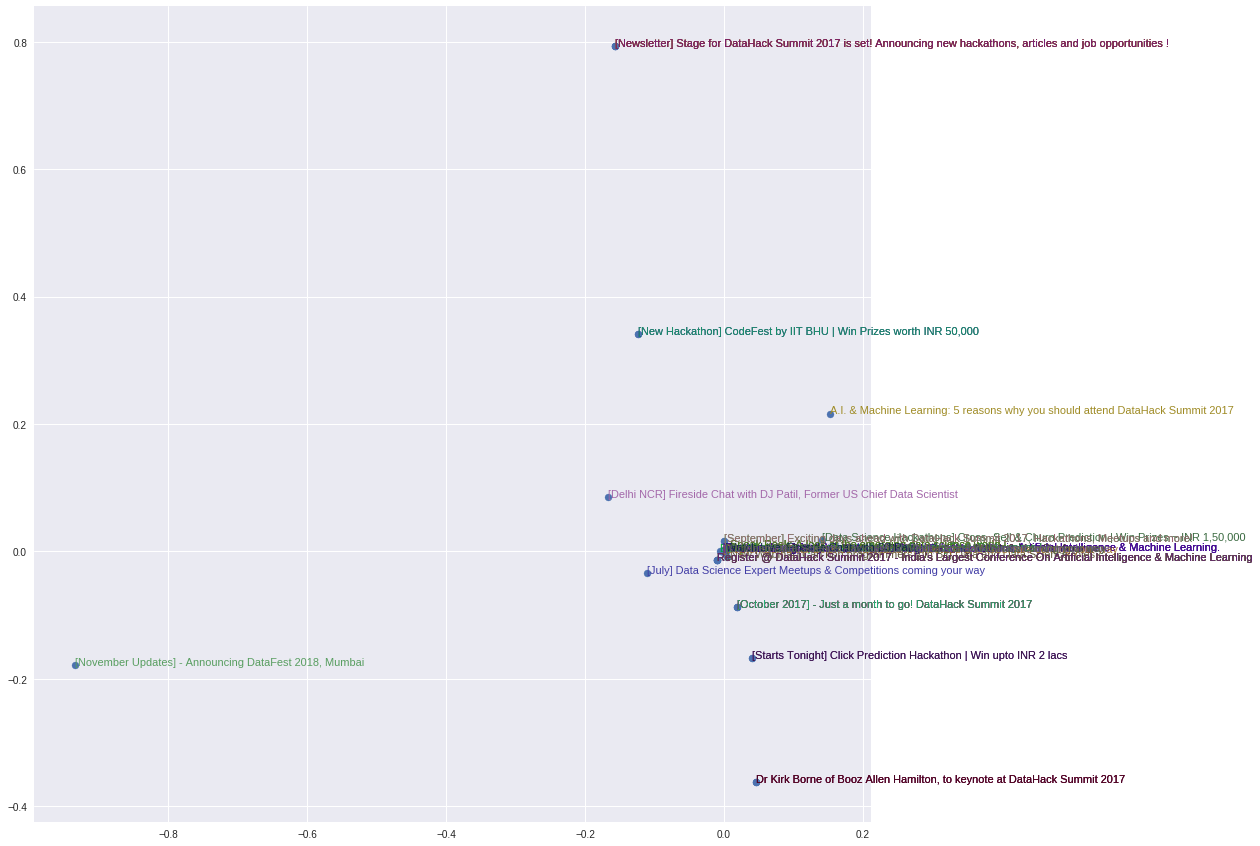

In [84]:
idxs = np.random.choice(len(topMovies), 50, replace=True)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example

In [0]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.FloatTensor of size 2x2], 
   2   2
  10  10
 [torch.FloatTensor of size 2x2])

In [0]:
a*b


  2   4
 30  40
[torch.FloatTensor of size 2x2]

In [0]:
(a*b).sum(1)


  6
 70
[torch.FloatTensor of size 2]

In [0]:
class DotProduct(nn.Module):
    def forward(self, u, m): return (u*m).sum(1)

In [0]:
model=DotProduct()

In [0]:
model(a,b)


  6
 70
[torch.FloatTensor of size 2]

### Dot product model

In [6]:
ratings1 = pd.read_csv('train.csv')
ratings1.head()

,id,user_id,campaign_id,send_date,is_open,is_click
0,42_14051,14051,42,01-09-2017 19:55,0,0
1,52_134438,134438,52,02-11-2017 12:53,0,0
2,33_181789,181789,33,24-07-2017 15:15,0,0
3,44_231448,231448,44,05-09-2017 11:36,0,0
4,29_185580,185580,29,01-07-2017 18:01,0,0


In [0]:
val_idxs = get_cv_idxs(len(ratings1))
wd=2e-4
n_factors = 50

In [8]:
u_uniq = ratings1.user_id.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings1.user_Id = ratings1.user_id.apply(lambda x: user2idx[x])

m_uniq = ratings1.campaign_id.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings1.campaign_id = ratings1.campaign_id.apply(lambda x: movie2idx[x])

n_users=int(ratings1.user_id.nunique())
n_movies=int(ratings1.campaign_id.nunique())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
class EmbeddingDot(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05)
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1)

In [0]:
x = ratings1.drop(['is_open', 'send_date'],axis=1)
y = ratings1['is_open'].astype(np.float32)

In [0]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['user_id', 'campaign_id'], 64)

In [0]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [13]:
fit(model, data, 3, opt, F.mse_loss)

Widget Javascript not detected.  It may not be installed or enabled properly.


  0%|          | 0/12790 [00:00<?, ?it/s]


RuntimeError: ignored

In [0]:
set_lrs(opt, 0.01)

In [27]:
fit(model, data, 3, opt, F.mse_loss)

Widget Javascript not detected.  It may not be installed or enabled properly.


  0%|          | 0/12790 [00:00<?, ?it/s]

RuntimeError: ignored

### Bias

In [0]:
min_rating,max_rating = ratings1.is_open.min(),ratings1.is_open.max()
min_rating,max_rating

(0.5, 5.0)

In [0]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze()
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating
        return res

In [0]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [0]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.88212  0.83626]                                    
[ 1.       0.8108   0.81831]                                    
[ 2.       0.78864  0.80989]                                    



In [0]:
set_lrs(opt, 1e-2)

In [0]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.72795  0.80337]                                    
[ 1.       0.75064  0.80203]                                    
[ 2.       0.75122  0.80124]                                    



### Mini net

In [0]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [0]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda()
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [0]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.88043  0.82363]                                    
[ 1.       0.8941   0.81264]                                    
[ 2.       0.86179  0.80706]                                    



In [0]:
set_lrs(opt, 1e-3)

In [0]:
fit(model, data, 3, opt, F.mse_loss)

A Jupyter Widget

[ 0.       0.7669   0.78622]                                    
[ 1.       0.74277  0.78152]                                    
[ 2.       0.69891  0.78075]                                    

